In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from scipy.special import comb
from scipy.stats import gaussian_kde, norm
import pandas as pd
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot
from lenstools.statistics.samplers import emcee_sampler
from itertools import cycle
import seaborn as sns
import emcee
from matplotlib.colors import LogNorm
from multiprocessing import Pool
from scipy.stats import skew
from scipy.stats import kurtosis as kurt

In [6]:
def standard_error_skew(n):
    return np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))

In [7]:
def standard_error_kurt(n):
    return np.sqrt(24*n*(n-1)**2/((n-3)*(n-2)*(n+3)*(n+5)))

In [8]:
datapath = "../powerspec.csv"
data = pd.read_csv(datapath)
data.pop("Unnamed: 0")
ell_bins = [f"ell{i}" for i in range(37)]

In [9]:
ell = np.logspace(np.log10(500), np.log10(5000),37)
train_data = data[ell_bins].to_numpy()

_, unique_idx = np.unique(train_data, return_index=True,axis=0)
train_data = train_data[unique_idx]

# Preprocessing

In [10]:
centered_data = train_data - np.mean(train_data,axis=0)

BIG_cov = np.cov(train_data.T)

L = np.linalg.cholesky(np.linalg.inv(BIG_cov))

prepro_data = centered_data @ L

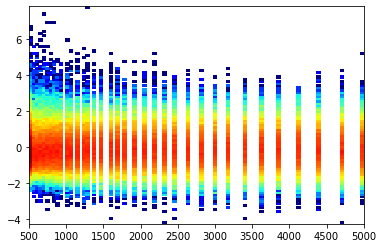

In [11]:
# Prepare data for trained sampled data points
ind = np.random.randint(0,prepro_data.shape[0],5000)
smp_real_data = prepro_data[ind]
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())

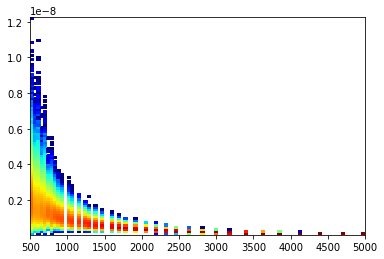

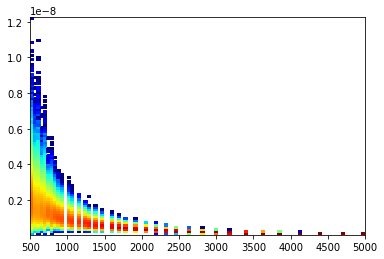

In [12]:
rereversed_data = (prepro_data ) @ np.linalg.inv(L) + np.mean(train_data,axis=0)

# Prepare data for trained sampled data points
smp_real_data = rereversed_data
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())
plt.show()

# plot OG data for comparison
smp_real_data = train_data
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())
plt.show()

# GMM

In [13]:
gmm = GMM(n_components=2)
# Train gmm on log of power spectrum
gmm.fit(prepro_data)

GaussianMixture(n_components=2)

In [14]:
t_skew_real_set = []
t_kurt_real_set = []
t_skew_gmm_set = []
t_kurt_gmm_set = []

n_samples = 2048
np.random.seed(42)

SE_skew = standard_error_skew(n_samples)
SE_kurt = standard_error_kurt(n_samples)

for i in range(100):
    # Randomly sample from training data
    ind = np.random.randint(0,prepro_data.shape[0],n_samples)
    smp_real_data = prepro_data[ind]
    real_skew = skew(smp_real_data,axis=0)
    real_kurt = kurt(smp_real_data,axis=0)
    
    # Gmm was trained on log of data, so scale back to normal with np.exp
    smp_gmm_data = gmm.sample(n_samples=n_samples)[0]
    gmm_skew = skew(smp_gmm_data,axis=0)
    gmm_kurt = kurt(smp_gmm_data,axis=0)
    
    t_skew_real = real_skew/SE_skew
    t_skew_real_set.append(t_skew_real)
    
    t_kurt_real = real_kurt/SE_kurt
    t_kurt_real_set.append(t_kurt_real)
    
    t_skew_gmm = gmm_skew/SE_skew
    t_skew_gmm_set.append(t_skew_gmm)
    
    t_kurt_gmm = gmm_kurt/SE_kurt
    t_kurt_gmm_set.append(t_kurt_gmm)

avg_t_skew_real = np.array(t_skew_real_set).mean(axis=0)
std_t_skew_real = np.array(t_skew_real_set).std(axis=0)

avg_t_kurt_real = np.array(t_kurt_real_set).mean(axis=0)
std_t_kurt_real = np.array(t_kurt_real_set).std(axis=0)

avg_t_skew_gmm = np.array(t_skew_gmm_set).mean(axis=0)
std_t_skew_gmm = np.array(t_skew_gmm_set).std(axis=0)

avg_t_kurt_gmm = np.array(t_kurt_gmm_set).mean(axis=0)
std_t_kurt_gmm = np.array(t_kurt_gmm_set).std(axis=0)

# t-statistics test

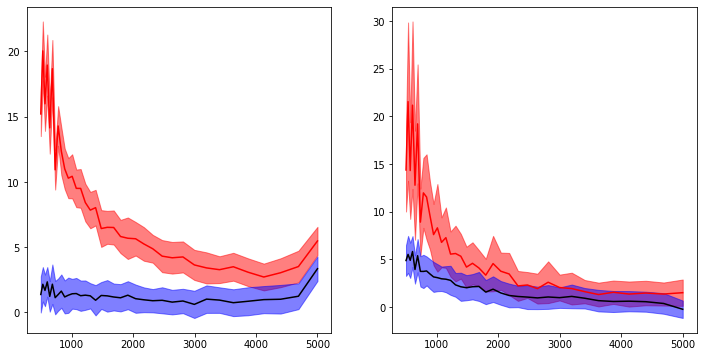

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(ell,avg_t_skew_real,'r-')
ax[0].fill_between(ell,avg_t_skew_real+std_t_skew_real,avg_t_skew_real-std_t_skew_real,alpha=0.5,color='r')
ax[0].plot(ell,avg_t_skew_gmm,'k-')
ax[0].fill_between(ell,avg_t_skew_gmm+std_t_skew_gmm,avg_t_skew_gmm-std_t_skew_gmm,alpha=0.5,color='b')

ax[1].plot(ell,avg_t_kurt_real,'r-')
ax[1].fill_between(ell,avg_t_kurt_real+std_t_kurt_real,avg_t_kurt_real-std_t_kurt_real,alpha=0.5,color='r')
ax[1].plot(ell,avg_t_kurt_gmm,'k-')
ax[1].fill_between(ell,avg_t_kurt_gmm+std_t_kurt_gmm,avg_t_kurt_gmm-std_t_kurt_gmm,alpha=0.5,color='b')

plt.show()

# GMM power spectrum

In [16]:
# Prepare data for GMM sampled data points
smp_gmm_data = gmm.sample(n_samples=n_samples)[0]
ells = smp_gmm_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_gmm_data)))).T
l = ells[:, 1]
P = ells[:,0]

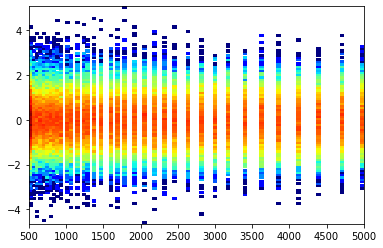

In [17]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())

# Mock data power spectrum

In [18]:
# Prepare data for trained sampled data points
ind = np.random.randint(0,train_data.shape[0],n_samples)
smp_real_data = train_data[ind]
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

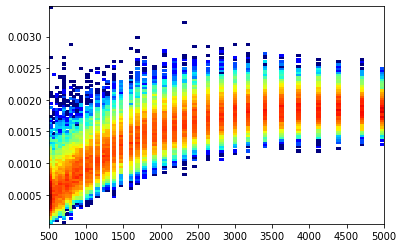

In [19]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,l*(l+1)*P, bins=100, cmap="jet", norm=LogNorm())

## KL Divergence /w MVN

In [20]:
from scipy.stats import multivariate_normal

#mvn = multivariate_normal.pdf(prepro_data,
#                              np.mean(prepro_data,axis=0),
#                              np.cov(prepro_data.T))

mvn_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                     cov=np.cov(prepro_data.T),
                                     size=2048)

In [21]:
mvn_samples[:2]

array([[ 0.82517256, -1.55839374,  0.69422651,  0.34426676,  1.29777913,
         0.6617607 ,  0.1818585 ,  0.26136899,  0.00544537,  1.12830102,
        -0.22815553,  1.02219435,  1.7715117 ,  1.12523371,  0.23223264,
         0.03128676,  0.72697033,  0.29397579, -1.8064178 ,  1.60727957,
         0.29059679, -1.93495981, -0.06480625, -0.32678682, -0.01750719,
        -0.39738863, -0.93980498, -0.07716336,  1.00592862, -0.94851639,
        -1.29524738,  0.03985243,  1.32101875, -1.37524174, -1.11468419,
        -0.86884313, -0.09775459],
       [-1.41635767, -0.67959337, -0.62320967, -0.4996712 ,  0.52850324,
         0.56736844, -1.4140842 , -0.26179684, -0.82103404,  0.94448042,
         0.49535898,  0.70685906,  0.96969618, -0.3986514 , -0.5695255 ,
        -0.57488768,  0.27682769, -0.62476769,  0.60473767,  0.02011547,
         1.42099128, -2.49986216, -0.40585562, -1.32222723, -0.51214962,
         0.41483185, -1.38695203,  1.2349105 ,  0.59317078, -1.18746808,
        -1.11256

In [22]:
gmm_samples = gmm.sample(n_samples=2048)[0]
gmm_samples[:2]

array([[ 1.25764608,  1.15135929, -1.36080267, -0.96913776, -0.77906969,
         2.34052192,  1.6898085 , -0.94220386,  0.13407562, -0.74643514,
         0.32546748,  0.69910588, -0.10581595,  0.84438231,  0.40896072,
         0.54948533,  0.27043959,  2.45749007, -0.45491666,  0.06323652,
        -1.11028191,  0.81873649, -0.63021286,  0.05782797, -0.87120798,
        -0.81240317,  1.14468481,  0.91995796,  1.06771478, -2.15611599,
        -0.63707288, -1.40366319, -0.66311268, -0.1850376 ,  1.75185727,
        -1.91092853,  0.26303473],
       [ 0.92232659, -0.66008775, -0.24712837, -1.15238443, -1.49380658,
         1.82548313, -0.5004508 ,  0.3330925 , -0.24785113,  2.9638376 ,
         1.25884025, -0.73073062,  1.1384324 , -1.00947783, -1.1268302 ,
         0.44632477,  1.11136159,  0.73990893,  1.39607614,  1.60651705,
         0.26816835, -1.24874946, -0.6679426 ,  1.30036826, -0.33028846,
         0.89446966,  0.61807303,  0.06006573, -1.33517898, -1.74217303,
         0.39313

In [23]:
def KL(X, Y, d=37):
    # see eq 23   
    n = X.shape[0]
    m = Y.shape[0]
    
    nu_k = np.zeros(n)
    rho_k = np.zeros(n)
    
    for i in range(n):
        rho_k_dist = np.sum((X - X[i])**2,axis=1)**0.5
        rho_k_dist[rho_k_dist==0] = 999 # lazy cheat
        #bad_idx = rho_k_dist==999
        rho_k[i] = np.min(rho_k_dist)
        
        
        nu_k_dist = np.sum((Y - X[i])**2,axis=1)**0.5
        nu_k[i] = np.min(nu_k_dist)

    return d/n * np.sum(np.log(nu_k/rho_k)) + np.log(m/(n-1))

In [24]:
KL_MVN = []
KL_GMM = []
KL_ref = []

for i in range(25):
    if i%5==0: print(str(i)+'...')
    
    mvn_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                     cov=np.cov(prepro_data.T),
                                     size=2048)
    
    mvn2_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                 cov=np.cov(prepro_data.T),
                                 size=2048)
    
    gmm_samples = gmm.sample(n_samples=2048)[0]
    
    ind = np.random.randint(0,prepro_data.shape[0],2048)
    mock_samples = prepro_data[ind]
    
    KL_GMM.append(KL(mock_samples,gmm_samples))
    KL_MVN.append(KL(mock_samples,mvn_samples))
    KL_ref.append(KL(mvn_samples,mvn2_samples))

0...


KeyboardInterrupt: 

In [ ]:
n3, bins2, patches3 = plt.hist(KL_ref, 10, density=True, facecolor='k', alpha=0.75,label='MVM|MVN')
n, bins, patches = plt.hist(KL_GMM, 10, density=True, facecolor='g', alpha=0.75,label='mock|GMM')
n2, bins2, patches3 = plt.hist(KL_MVN, 10, density=True, facecolor='r', alpha=0.75,label='mock|MVN')


plt.xlabel('KL')
plt.legend()
plt.show()
plt.tight_layout()

# Pairwise

In [167]:
def svd_whiten(X):

    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

def pairwise(X, d=37, b=10):
    """
    Pairs bins as described in III.B for a single power spectra
    """  
    n = X.shape[0]
    # preprocess bin by standardization 
    _X = X.copy()
    _X = (_X - _X.mean(axis=0))/_X.std(axis=0)
    
    x = np.linspace(-4, 4, b) # point where we evaluate the the KDE
    total = comb(d, 2)
    # get paired bins (eq 18)
    H_b = []
    ell = 0
    for i in range(d):
        for j in range(i+1, d):
            # preprocessing -> whiten the data
            cov = np.cov(_X[:, (i, j)].T)
#             pca = PCA(whiten=True)
#             pairs = pca.fit_transform(_X[:, (i, j)])
            # (PCA whitening)
            Sigma, V = np.linalg.eig(cov)
            # prevent very small eigen values to have too much weight
            D = np.diag(np.sqrt(1/(Sigma + 1e-20)))
            # whitening matrix 
            W = V @ D @ V.T
            pairs = np.einsum("...i, ij -> ...i", _X[:, (i, j)], W)
            
            # fit a kde on the sum
            s = pairs[:, 0] + pairs[:, 1]
            K = gaussian_kde(s) # scott bandwidth by default
            
            # get the pdf value at given points
            s = K.pdf(x)
            H_b.append(s)
            print(f"\r pairwise status: {ell}/{total-1:d}", end="", flush=True)
            ell += 1
    
    H_b = np.array(H_b)    
    return H_b.T, x

def transcovariance_score(X):
    d=37
    Hb, x = pairwise(X, d=37)
    
    X = np.tile(x, (Hb.shape[1], 1)).T
    
    # mean integrated square error
    mise = ((Hb - norm.pdf(X, 0, 2) )**2).mean(axis=0)
    
    epsilon_plus = np.zeros(d)
    for i in range(d):
        j = [k for k in range(d) if k != i]
        epsilon_plus[i] = mise[j].sum()
    return epsilon_plus


In [168]:
eps = transcovariance_score(train_data)

665/666.0

In [169]:
eps

array([0.09817224, 0.09820511, 0.09807209, 0.09850403, 0.09821226,
       0.09851482, 0.09850807, 0.09859751, 0.09855795, 0.09875906,
       0.09873479, 0.09880939, 0.09880806, 0.09887158, 0.09901734,
       0.09886608, 0.09893446, 0.09904404, 0.09907682, 0.09919715,
       0.09917139, 0.09931599, 0.09917482, 0.09921516, 0.09922862,
       0.09936548, 0.09933064, 0.09938444, 0.0994617 , 0.09936367,
       0.09937798, 0.09943066, 0.09947643, 0.09954751, 0.09959167,
       0.09953114, 0.09830136])